# This notebook is designed for teaching/testing purposes to help you visualize the tensor shapes that go through each module

In [3]:
# my virtual environments are rarely properly connected to jupyter so this fixes that. 
# you prolly won't need this cell but running it won't hurt anything either
import sys
import os
current_dir = os.getcwd()  # Get the current working directory
venv_dir = os.path.join(current_dir, 'venv') 
python_version = str(sys.version_info.major) + '.' + str(sys.version_info.minor)
site_packages_path = os.path.join(venv_dir, 'lib', 'python' + python_version, 'site-packages')
sys.path.append(site_packages_path) 

In [4]:
# config file
from config import ModelConfig, TrainConfig
cfg = ModelConfig()
tcfg = TrainConfig()
print(cfg)
print(tcfg)

# import the tokenizer specified by cfg
from tools import import_from_nested_path
imported_objects = import_from_nested_path(['tokenizers', cfg.tokenizer], 'tokenizer', ['get_tokenizer'])
get_tokenizer = imported_objects.get('get_tokenizer')
tokenizer = get_tokenizer(size = 512) # assuming 'bpe_tinyStories', size options are 512, 1024 and 2048

import random
import torch

ModelConfig(dim=4, device='mps', linear_bias=False, out_weight_share=True, max_seq_len=7, pos_enc_type='RoPE', theta=10000, tokenizer='bpe_tinyStories', vocab_len=2048, num_layers=2, second_resid_norm=False, mlp_hidden_mult=2, mlp_nonlinearity='SiLU', mlp_gated=True, num_q_heads=2, num_kv_heads=1, head_dim=2, scale_first_resid=True, norm_type='RMSNorm', norm_affine=True, norm_bias=True, eps=1e-06)
TrainConfig(model_name='2024-09-21|18-14-17', dataset_name='noanabeshima/TinyStoriesV2', data_subset=None, streaming=True, micro_batch_size=3, grad_accum_steps=2, max_iters=20, eval_interval=2, eval_samples=1, checkpoint_interval=None, beta1=0.9, beta2=0.95, epsilon=1e-08, weight_decay=0.05, grad_clip=1.0, lr_init=1e-06, lr_max=0.01, lr_min=0.0001, warmup_iters=2, final_flat_iters=1, anneal_type='cos', num_restarts=0, T_mult=2)


# Norms

In [6]:
from modules.norm import Norm

In [7]:
%%time

### RMSNorm

# Create an instance of RMSNorm
module = Norm(cfg.dim, 'RMSNorm').to(cfg.device)

# let's take a look
print("number of parameters: %.2fK" % (module.get_num_params()/1e3,))
print(module)

# Initially, logging is disabled by default
module.enable_logging()

### Optionally disabling printing for sub-functions
#module.disable_function_logging('CosineNorm')
#module.disable_function_logging('LayerNorm')
#module.disable_function_logging('RMSNorm')

x = torch.randn(tcfg.micro_batch_size,cfg.max_seq_len,cfg.dim).to(cfg.device)

# Call the forward method - logging will occur
output = module(x)

# Disable logging. 
# This isn't actually necessary since we won't be using this object again but that's how you'd do it
module.disable_logging()

# clearing up ram jic we're training later
del module, x, output

number of parameters: 0.01K
Norm()

====================Entering Norm.forward====================
Inputs:
Tensor 'x' shape: torch.Size([3, 7, 4]), dtype: torch.float32, device: mps:0, min/max: -2.561/2.554

====================Entering Norm.RMSNorm====================
Inputs:
Tensor 'x' shape: torch.Size([3, 7, 4]), dtype: torch.float32, device: mps:0, min/max: -2.561/2.554

Outputs:
Tensor 'output' shape: torch.Size([3, 7, 4]), dtype: torch.float32, device: mps:0, min/max: -1.869/1.779
====================Exiting Norm.RMSNorm====================

Outputs:
Tensor 'output' shape: torch.Size([3, 7, 4]), dtype: torch.float32, device: mps:0, min/max: -1.869/1.779
====================Exiting Norm.forward====================
CPU times: user 67.9 ms, sys: 89.4 ms, total: 157 ms
Wall time: 205 ms


In [8]:
%%time

# LayerNorm
module = Norm(cfg.dim, 'LayerNorm').to(cfg.device)
module.enable_logging()

# you can also have it optionally print out all tensors in full
module.enable_full_tensor_printing()
# i recommend only doing this with very small toy values for your hyperparameters, otherwise this gets too big

### Optionally disabling printing for sub-functions
#module.disable_function_logging('CosineNorm')
#module.disable_function_logging('LayerNorm')
#module.disable_function_logging('RMSNorm')

x = torch.randn(tcfg.micro_batch_size,cfg.max_seq_len,cfg.dim).to(cfg.device)
output = module(x)
del module, x, output


====================Entering Norm.forward====================
Inputs:
Tensor 'x' shape: torch.Size([3, 7, 4]), dtype: torch.float32, device: mps:0, min/max: -2.527/2.251
Full tensor content:
tensor([[[-0.5230, -0.9381,  0.2263,  0.3828],
         [-0.0262, -1.1933,  0.5411,  0.0104],
         [ 0.3228, -0.1952, -0.0802, -0.5512],
         [-0.8007,  1.1186,  0.0894, -0.4256],
         [ 0.2103,  1.4038,  0.5134, -1.2763],
         [-0.3193,  0.8299, -1.4546,  0.3746],
         [ 0.3534,  0.5855, -1.6108, -0.2388]],

        [[ 0.0135, -1.2019, -0.0754,  1.0510],
         [-1.0081,  1.4370,  1.4895,  0.1814],
         [ 1.4942,  0.1192, -0.7754, -0.1897],
         [ 1.8967, -0.5758,  0.1719,  1.6467],
         [-0.2362,  0.8676,  1.0817, -1.0754],
         [ 0.3650, -0.1457, -0.8078,  0.2125],
         [-0.2432, -0.8513, -0.8021,  0.8021]],

        [[ 0.0959, -0.0041,  1.6662, -0.0043],
         [ 0.4034, -0.7618,  0.4126,  0.2836],
         [-1.6668, -1.8566, -0.2972, -0.5777],
     

# Attention

In [10]:
from modules.attention import SelfAttention, PrecomputeRotaryFrequencies

## training

In [12]:
%%time

# first up let's look at training

# Create an instance of multi-head self-attention
module = SelfAttention(cfg.dim, cfg.head_dim, cfg.num_q_heads, cfg.num_kv_heads, cfg.max_seq_len, cfg.linear_bias, device=cfg.device)
print("number of parameters: %.2fK" % (module.get_num_params()/1e3,))
print(module)

# Initially, logging is disabled by default
module.enable_logging()

### Optionally disabling printing for sub-functions
#module.disable_function_logging('splice_specific_frequencies')
#module.disable_function_logging('apply_rotary_pos_emb')
#module.disable_function_logging('rotate_half')
#module.disable_function_logging('implement_kv_caching')
#module.disable_function_logging('update_kv_cache')
#module.disable_function_logging('use_kv_cache')
#module.disable_function_logging('match_headcount')
#module.disable_function_logging('flash_attention')
#module.disable_function_logging('regular_attention')
#module.disable_function_logging('adjust_inference_mask')
#module.disable_function_logging('project_values')

# optionally enabling printing of every single input/output tensor
#module.enable_full_tensor_printing()

# precompute RoPE frequencies, causal mask, and dummy input data
if cfg.pos_enc_type == 'RoPE':
    precompute_freqs = PrecomputeRotaryFrequencies(cfg.head_dim, cfg.max_seq_len, cfg.theta, cfg.device)
    freqs = precompute_freqs()
else:
    precompute_freqs = None
    freqs = None
mask = torch.ones(cfg.max_seq_len, cfg.max_seq_len, dtype=torch.bool, device=cfg.device).tril()
x = torch.randn(tcfg.micro_batch_size,cfg.max_seq_len,cfg.dim).to(cfg.device)

# Call the forward method - logging will occur
output = module(x, freqs, mask, training=True)

# clearing up ram jic we're training later
del module, precompute_freqs, freqs, mask, x, output

number of parameters: 0.05K
SelfAttention(
  (Wq): Linear(in_features=4, out_features=4, bias=False)
  (Wk): Linear(in_features=4, out_features=2, bias=False)
  (Wv): Linear(in_features=4, out_features=2, bias=False)
  (Wo): Linear(in_features=4, out_features=4, bias=False)
)

====================Entering SelfAttention.forward====================
Inputs:
Tensor 'x' shape: torch.Size([3, 7, 4]), dtype: torch.float32, device: mps:0, min/max: -1.444/2.281
Dict 'freqs':
    Tensor 'freqs[cos]' shape: torch.Size([1, 7, 1, 2]), dtype: torch.float32, device: mps:0, min/max: -0.990/1.000
    Tensor 'freqs[sin]' shape: torch.Size([1, 7, 1, 2]), dtype: torch.float32, device: mps:0, min/max: -0.959/0.909
Tensor 'mask' shape: torch.Size([7, 7]), dtype: torch.bool, device: mps:0, min/max: 0.000/1.000
Other-type 'cache_len': Type=NoneType, Value=None
Other-type 'kv_cache': Type=NoneType, Value=None
Bool 'training': Value=True

====================Entering SelfAttention.apply_rotary_pos_emb==========

## inference 
full kv-caching process with variable sequence length initial prompts in batch and then single-vector auto-regressive inference

In [14]:
%%time

# now let's do it for INFERENCE with the full kv-caching process 
    # meaning initial variable length prompts AND successive auto-regressive single-token input
# here we'll be pretending we're using a model where every single layer is just self-attention, no MLP or residual connection

module = SelfAttention(cfg.dim, cfg.head_dim, cfg.num_q_heads, cfg.num_kv_heads, cfg.max_seq_len, cfg.linear_bias, device=cfg.device)
module.enable_logging()

### Optionally disabling printing for sub-functions
#module.disable_function_logging('splice_specific_frequencies')
#module.disable_function_logging('apply_rotary_pos_emb')
#module.disable_function_logging('rotate_half')
#module.disable_function_logging('implement_kv_caching')
#module.disable_function_logging('update_kv_cache')
#module.disable_function_logging('use_kv_cache')
#module.disable_function_logging('match_headcount')
#module.disable_function_logging('flash_attention')
#module.disable_function_logging('regular_attention')
#module.disable_function_logging('adjust_inference_mask')
#module.disable_function_logging('project_values')

# optionally enabling printing of every single input/output tensor
#module.enable_full_tensor_printing()

# so half the max_seq_len will be the length of our longest prompt in batched inference that needs to be cached
x = torch.randn(tcfg.micro_batch_size,cfg.max_seq_len // 2,cfg.dim).to(cfg.device) 

# precompute RoPE frequencies, causal mask, and dummy input data
if cfg.pos_enc_type == 'RoPE':
    precompute_freqs = PrecomputeRotaryFrequencies(cfg.head_dim, cfg.max_seq_len, cfg.theta, cfg.device)
    freqs = precompute_freqs()
else:
    precompute_freqs = None
    freqs = None
    
# setting up for kv caching
kv_cache = {
    'k': torch.zeros((tcfg.micro_batch_size, cfg.max_seq_len, cfg.num_kv_heads, cfg.head_dim), device=cfg.device),
    'v': torch.zeros((tcfg.micro_batch_size, cfg.max_seq_len, cfg.num_kv_heads, cfg.head_dim), device=cfg.device)
}

# mask ignores padding tokens and accounts for variable sequence lengths
mask = torch.ones(tcfg.micro_batch_size, cfg.max_seq_len // 2).to(cfg.device).bool() # (True for real tokens, False for padding)
# we'll simulate a mask setup for different-length input prompts
for s in range(mask.shape[0] - 1): # -1 leaves the last row as the full longest prompt length
    r = random.randint(1, cfg.max_seq_len // 2-1)
    mask[s, -r:] = False
print('mask:\n', mask)

cache_len = mask.sum(1).to(cfg.device).long()
print('cache_len:\n', cache_len, cache_len.shape)

# Call the forward method - logging will occur
output, kv_cache = module(x, freqs, mask, cache_len, kv_cache)

input = output[:,-1:,:]
for _ in range(2): # we'll do it twice
    mask = torch.nn.functional.pad(mask, (1, 0, 0, 0), value=True)
    cache_len += 1
    print('mask:\n', mask)
    print('cache_len:\n', cache_len, cache_len.shape)

    output, kv_cache = module(input, freqs, mask, cache_len, kv_cache)
    input = output

print(output)
    
# clearing up ram jic we're training later
del module, x, precompute_freqs, freqs, kv_cache, mask, cache_len, output

mask:
 tensor([[ True, False, False],
        [ True,  True, False],
        [ True,  True,  True]], device='mps:0')
cache_len:
 tensor([1, 2, 3], device='mps:0') torch.Size([3])

====================Entering SelfAttention.forward====================
Inputs:
Tensor 'x' shape: torch.Size([3, 3, 4]), dtype: torch.float32, device: mps:0, min/max: -2.958/1.779
Dict 'freqs':
    Tensor 'freqs[cos]' shape: torch.Size([1, 7, 1, 2]), dtype: torch.float32, device: mps:0, min/max: -0.990/1.000
    Tensor 'freqs[sin]' shape: torch.Size([1, 7, 1, 2]), dtype: torch.float32, device: mps:0, min/max: -0.959/0.909
Tensor 'mask' shape: torch.Size([3, 3]), dtype: torch.bool, device: mps:0, min/max: 0.000/1.000
Tensor 'cache_len' shape: torch.Size([3]), dtype: torch.int64, device: mps:0, min/max: 1.000/3.000
Dict 'kv_cache':
    Tensor 'kv_cache[k]' shape: torch.Size([3, 7, 1, 2]), dtype: torch.float32, device: mps:0, min/max: 0.000/0.000
    Tensor 'kv_cache[v]' shape: torch.Size([3, 7, 1, 2]), dtype: to

# Multi-Layer Perceptron

In [16]:
from modules.mlp import MLP

In [17]:
%%time

# GeGLU
module = MLP(
    cfg.dim, 
    int(cfg.dim * cfg.mlp_hidden_mult * 2/3), 
    cfg.dim, 
    'GeLU', 
    gated=True, 
    bias=cfg.linear_bias, 
    dropout_rate = 0.1
).to(cfg.device)
print("number of parameters: %.2fK" % (module.get_num_params()/1e3,))
print(module)
module.enable_logging()

# optionally enabling printing of every single input/output tensor
#module.enable_full_tensor_printing()

x = torch.randn(tcfg.micro_batch_size,cfg.max_seq_len,cfg.dim).to(cfg.device)
output = module(x, training=True)
module.disable_logging()
del module, x, output

number of parameters: 0.06K
MLP(
  (Wup): Linear(in_features=4, out_features=5, bias=False)
  (Wgate): Linear(in_features=4, out_features=5, bias=False)
  (Wdown): Linear(in_features=5, out_features=4, bias=False)
  (nonlinearity): GELU(approximate='none')
)

====================Entering MLP.forward====================
Inputs:
Tensor 'x' shape: torch.Size([3, 7, 4]), dtype: torch.float32, device: mps:0, min/max: -2.376/2.221
Bool 'training': Value=True

Outputs:
Tensor 'output' shape: torch.Size([3, 7, 4]), dtype: torch.float32, device: mps:0, min/max: -0.268/0.310
====================Exiting MLP.forward====================
CPU times: user 28.2 ms, sys: 4.64 ms, total: 32.8 ms
Wall time: 37.4 ms


In [18]:
%%time

# not gated and testing a different nonlinearity
module = MLP(
    cfg.dim, 
    cfg.dim * cfg.mlp_hidden_mult, 
    cfg.dim, 
    'ReLU', 
    gated=False, 
    bias=True, 
    dropout_rate = 0.1
).to(cfg.device)
print("number of parameters: %.2fK" % (module.get_num_params()/1e3,))
print(module)
module.enable_logging()

# optionally enabling printing of every single input/output tensor
#module.enable_full_tensor_printing()

x = torch.randn(tcfg.micro_batch_size,cfg.max_seq_len,cfg.dim).to(cfg.device)
output = module(x, training=True)
module.disable_logging()
del module, x, output

number of parameters: 0.08K
MLP(
  (Wup): Linear(in_features=4, out_features=8, bias=True)
  (Wdown): Linear(in_features=8, out_features=4, bias=True)
  (nonlinearity): ReLU()
)

====================Entering MLP.forward====================
Inputs:
Tensor 'x' shape: torch.Size([3, 7, 4]), dtype: torch.float32, device: mps:0, min/max: -2.692/2.495
Bool 'training': Value=True

Outputs:
Tensor 'output' shape: torch.Size([3, 7, 4]), dtype: torch.float32, device: mps:0, min/max: -0.732/1.236
====================Exiting MLP.forward====================
CPU times: user 27.6 ms, sys: 4.46 ms, total: 32 ms
Wall time: 34.5 ms


# ResidualLayer

In [20]:
from modules.layer import Layer

## training

In [22]:
%%time

# TRAINING
module = Layer(cfg).to(cfg.device)
print("number of parameters: %.2fK" % (module.get_num_params()/1e3,))
print(module)

module.enable_logging()
### Optionally disabling printing for sub-modules
#module.disable_function_logging('attn_connect')
#module.disable_function_logging('mlp_connect')

### Optionally disabling printing for sub-functions
#module.pre_attn_norm.enable_logging()
#module.attn.enable_logging()
#module.post_attn_norm.enable_logging()
#module.pre_mlp_norm.enable_logging()
#module.mlp.enable_logging()
#module.post_mlp_norm.enable_logging()

# optionally enabling printing of every single input/output tensor
#module.enable_full_tensor_printing()

# precompute RoPE frequencies, causal mask, and dummy input data
if cfg.pos_enc_type == 'RoPE':
    precompute_freqs = PrecomputeRotaryFrequencies(cfg.head_dim, cfg.max_seq_len, cfg.theta, cfg.device)
    freqs = precompute_freqs()
else:
    precompute_freqs = None
    freqs = None
mask = torch.ones(cfg.max_seq_len, cfg.max_seq_len, dtype=torch.bool, device=cfg.device).tril()
print(mask)
x = torch.randn(tcfg.micro_batch_size,cfg.max_seq_len,cfg.dim).to(cfg.device)

output = module(x, freqs, mask, training=True)
module.disable_logging()
del module,freqs, mask, x, output

number of parameters: 0.12K
Layer(
  (pre_attn_norm): Norm()
  (attn): SelfAttention(
    (Wq): Linear(in_features=4, out_features=4, bias=False)
    (Wk): Linear(in_features=4, out_features=2, bias=False)
    (Wv): Linear(in_features=4, out_features=2, bias=False)
    (Wo): Linear(in_features=4, out_features=4, bias=False)
  )
  (pre_mlp_norm): Norm()
  (mlp): MLP(
    (Wup): Linear(in_features=4, out_features=5, bias=False)
    (Wgate): Linear(in_features=4, out_features=5, bias=False)
    (Wdown): Linear(in_features=5, out_features=4, bias=False)
    (nonlinearity): SiLU()
  )
)
tensor([[ True, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False],
        [ True,  True,  True, False, False, False, False],
        [ True,  True,  True,  True, False, False, False],
        [ True,  True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True]

## inference

In [24]:
%%time

# now let's do it for INFERENCE with the full kv-caching process 
    # meaning initial variable length prompts AND successive auto-regressive single-token input
# here we'll be pretending we're using a model that's just a single transformer block (resid, attn, mlp) called recurrently

module = Layer(cfg).to(cfg.device)
print("number of parameters: %.2fK" % (module.get_num_params()/1e3,))
print(module)

module.enable_logging()

### Optionally disabling printing for sub-modules
#module.disable_function_logging('attn_connect')
#module.disable_function_logging('mlp_connect')

### Optionally disabling printing for sub-functions
#module.pre_attn_norm.enable_logging()
#module.attn.enable_logging()
#module.post_attn_norm.enable_logging()
#module.pre_mlp_norm.enable_logging()
#module.mlp.enable_logging()
#module.post_mlp_norm.enable_logging()

# optionally enabling printing of every single input/output tensor
#module.enable_full_tensor_printing()

# so half the max_seq_len will be the length of our longest prompt in batched inference that needs to be cached
x = torch.randn(tcfg.micro_batch_size,cfg.max_seq_len // 2,cfg.dim).to(cfg.device)

# precompute RoPE frequencies, causal mask, and dummy input data
if cfg.pos_enc_type == 'RoPE':
    precompute_freqs = PrecomputeRotaryFrequencies(cfg.head_dim, cfg.max_seq_len, cfg.theta, cfg.device)
    freqs = precompute_freqs()
else:
    precompute_freqs = None
    freqs = None

# setting up for kv caching
kv_cache = {
    'k': torch.zeros((tcfg.micro_batch_size, cfg.max_seq_len, cfg.num_kv_heads, cfg.head_dim), device=cfg.device),
    'v': torch.zeros((tcfg.micro_batch_size, cfg.max_seq_len, cfg.num_kv_heads, cfg.head_dim), device=cfg.device)
}

# mask ignores padding tokens and accounts for variable sequence lengths
mask = torch.ones(tcfg.micro_batch_size, cfg.max_seq_len // 2).to(cfg.device).bool() # (True for real tokens, False for padding)
# we'll simulate a mask setup for different-length input prompts
for s in range(mask.shape[0] - 1): # -1 leaves the last row as the full longest prompt length
    r = random.randint(1, cfg.max_seq_len // 2-1)
    mask[s, -r:] = False
print('mask:\n', mask)

cache_len = mask.sum(1).to(cfg.device).long()
print('cache_len:\n', cache_len, cache_len.shape)

# Call the forward method - logging will occur
output, kv_cache = module(x, freqs, mask, cache_len, kv_cache)

input = output[:,-1:,:]
for _ in range(2): # we'll do it twice
    mask = torch.nn.functional.pad(mask, (1, 0, 0, 0), value=True)
    cache_len += 1
    print('mask:\n', mask)
    print('cache_len:\n', cache_len, cache_len.shape)

    output, kv_cache = module(input, freqs, mask, cache_len, kv_cache)
    input = output

print(output)

del module, x, precompute_freqs, freqs, kv_cache, mask, cache_len, output

number of parameters: 0.12K
Layer(
  (pre_attn_norm): Norm()
  (attn): SelfAttention(
    (Wq): Linear(in_features=4, out_features=4, bias=False)
    (Wk): Linear(in_features=4, out_features=2, bias=False)
    (Wv): Linear(in_features=4, out_features=2, bias=False)
    (Wo): Linear(in_features=4, out_features=4, bias=False)
  )
  (pre_mlp_norm): Norm()
  (mlp): MLP(
    (Wup): Linear(in_features=4, out_features=5, bias=False)
    (Wgate): Linear(in_features=4, out_features=5, bias=False)
    (Wdown): Linear(in_features=5, out_features=4, bias=False)
    (nonlinearity): SiLU()
  )
)
mask:
 tensor([[ True,  True, False],
        [ True,  True, False],
        [ True,  True,  True]], device='mps:0')
cache_len:
 tensor([2, 2, 3], device='mps:0') torch.Size([3])

====================Entering Layer.forward====================
Inputs:
Tensor 'x' shape: torch.Size([3, 3, 4]), dtype: torch.float32, device: mps:0, min/max: -1.424/2.057
Dict 'freqs':
    Tensor 'freqs[cos]' shape: torch.Size([1, 

# Full Model

In [26]:
from modules.model import Model
from inference import sampler

## training

In [28]:
%%time

# TRAINING
module = Model(cfg).to(cfg.device)
print("number of parameters: %.2fM" % (module.get_num_params()/1e6,))
print(module)

module.enable_logging()
### enabling printing for sub-modules
#module.precompute_freqs.enable_logging() # only un-comment this line if using RoPE
#module.layers[0].enable_logging()
for i in range(cfg.num_layers):
    module.layers[i].enable_logging()
module.final_norm.enable_logging()

# optionally enabling printing of every single input/output tensor
#module.enable_full_tensor_printing()

input_token_ids = torch.randint(tokenizer.vocab_len, (tcfg.micro_batch_size, cfg.max_seq_len)).to(cfg.device)
target_token_ids = torch.randint(tokenizer.vocab_len, (tcfg.micro_batch_size, cfg.max_seq_len)).to(cfg.device)

output, loss = module(input_token_ids, target_token_ids=target_token_ids)
print(output, '\n', loss)
del module, input_token_ids, target_token_ids, output, loss

number of parameters: 0.01M
Model(
  (precompute_freqs): PrecomputeRotaryFrequencies()
  (token_embedder): Embedding(2048, 4)
  (layers): ModuleList(
    (0-1): 2 x Layer(
      (pre_attn_norm): Norm()
      (attn): SelfAttention(
        (Wq): Linear(in_features=4, out_features=4, bias=False)
        (Wk): Linear(in_features=4, out_features=2, bias=False)
        (Wv): Linear(in_features=4, out_features=2, bias=False)
        (Wo): Linear(in_features=4, out_features=4, bias=False)
      )
      (pre_mlp_norm): Norm()
      (mlp): MLP(
        (Wup): Linear(in_features=4, out_features=5, bias=False)
        (Wgate): Linear(in_features=4, out_features=5, bias=False)
        (Wdown): Linear(in_features=5, out_features=4, bias=False)
        (nonlinearity): SiLU()
      )
    )
  )
  (final_norm): Norm()
  (output): Linear(in_features=4, out_features=2048, bias=False)
  (criterion): CrossEntropyLoss()
)

====================Entering Model.forward====================
Inputs:
Tensor 'input_

## inference

In [64]:
%%time

# Inference
module = Model(cfg).to(cfg.device)
print("number of parameters: %.2fM" % (module.get_num_params()/1e6,))
print(module)

module.enable_logging()
### enabling printing for sub-modules
#for i in range(cfg.num_layers):
    #module.layers[i].enable_logging()
#module.final_norm.enable_logging()

# optionally enabling printing of every single input/output tensor
#module.enable_full_tensor_printing()

# so half the max_seq_len will be the length of our longest prompt in batched inference that needs to be cached
input_token_ids = torch.randint(tokenizer.vocab_len, (tcfg.micro_batch_size, cfg.max_seq_len // 2)).to(cfg.device)

kv_cache = [{ # Initialize kv caches for each layer
                "k": torch.zeros((tcfg.micro_batch_size, cfg.max_seq_len, cfg.num_kv_heads, cfg.head_dim), device=cfg.device),
                "v": torch.zeros((tcfg.micro_batch_size, cfg.max_seq_len, cfg.num_kv_heads, cfg.head_dim), device=cfg.device),
            } for _ in range(cfg.num_layers)]

# mask ignores padding tokens and accounts for variable sequence lengths
mask = torch.ones(tcfg.micro_batch_size, cfg.max_seq_len // 2).to(cfg.device).bool() 
    # (True for real tokens, False for padding)
# we'll simulate a mask setup for different-length input prompts
for s in range(mask.shape[0] - 1): # -1 leaves the last row as the full longest prompt length
    r = random.randint(1, cfg.max_seq_len // 2-1)
    mask[s, -r:] = False
print('mask:\n', mask)

cache_len = mask.sum(1).to(cfg.device).long()
print('cache_len:\n', cache_len, cache_len.shape)

logits, kv_cache = module(input_token_ids, mask = mask, cache_len = cache_len, kv_cache = kv_cache)
print(f'logits: {logits.shape}')
next_token_batch = sampler(logits, cache_len=cache_len-1) # -1 ????
print(f'next_token_batch: {next_token_batch}')

for _ in range(2): # we'll do the single-input-vector autoregressive inference twice
    mask = torch.nn.functional.pad(mask, (1, 0, 0, 0), value=True)
    cache_len += 1
    print('mask:\n', mask)
    print('cache_len:\n', cache_len, cache_len.shape)

    logits, kv_cache = module(next_token_batch, mask = mask, cache_len = cache_len, kv_cache = kv_cache)
    
    next_token_batch = sampler(logits)
    print(f'logits: {logits.shape}\nnext_token_batch: {next_token_batch}')

del module, input_token_ids, kv_cache, mask, cache_len, logits, next_token_batch


number of parameters: 0.01M
Model(
  (precompute_freqs): PrecomputeRotaryFrequencies()
  (token_embedder): Embedding(2048, 4)
  (layers): ModuleList(
    (0-1): 2 x Layer(
      (pre_attn_norm): Norm()
      (attn): SelfAttention(
        (Wq): Linear(in_features=4, out_features=4, bias=False)
        (Wk): Linear(in_features=4, out_features=2, bias=False)
        (Wv): Linear(in_features=4, out_features=2, bias=False)
        (Wo): Linear(in_features=4, out_features=4, bias=False)
      )
      (pre_mlp_norm): Norm()
      (mlp): MLP(
        (Wup): Linear(in_features=4, out_features=5, bias=False)
        (Wgate): Linear(in_features=4, out_features=5, bias=False)
        (Wdown): Linear(in_features=5, out_features=4, bias=False)
        (nonlinearity): SiLU()
      )
    )
  )
  (final_norm): Norm()
  (output): Linear(in_features=4, out_features=2048, bias=False)
  (criterion): CrossEntropyLoss()
)
mask:
 tensor([[ True, False, False],
        [ True, False, False],
        [ True,  

# Other fun stuff

### Learning Rate Schedule Display
thought i'd make somewhere to help you visualize what the learning rate schedule settings you've got look like

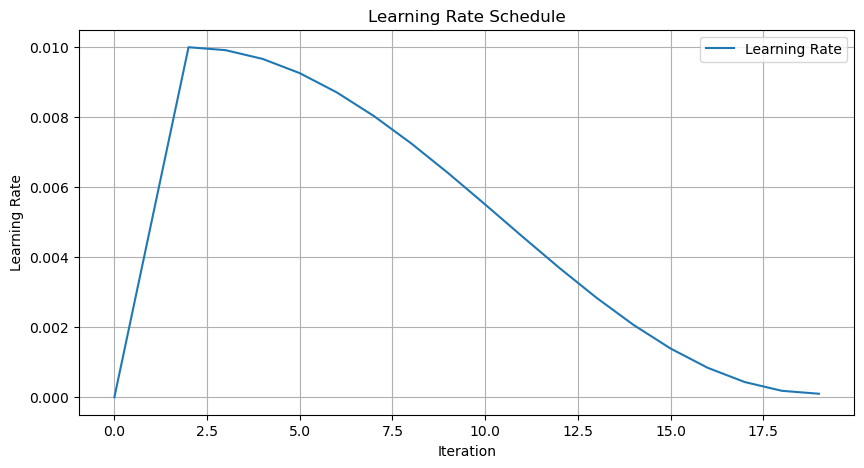

In [49]:
import matplotlib.pyplot as plt
from train import scheduler_lambda
from config import TrainConfig
tcfg = TrainConfig()
    
# Generate learning rate values
lrs = [scheduler_lambda(i) for i in range(tcfg.max_iters)]
    
# Plot the learning rates
plt.figure(figsize=(10, 5))
plt.plot(lrs, label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.legend()
plt.show()

### visualizing our tokenizer

In [75]:
from tools import import_from_nested_path
imported_objects = import_from_nested_path(['tokenizers', cfg.tokenizer], 'tokenizer', ['get_tokenizer'])
get_tokenizer = imported_objects.get('get_tokenizer')
tokenizer = get_tokenizer(size = cfg.vocab_len)
prompt = "Once upon a time"#'Once upon a time, there was a boy named Tim.'
tokenizer.display(prompt)

['Once', ' upon', ' a', ' time']